# Temperature Evaluation

## Temperature top 5 m

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
def bias(df, obs, mod):
    return len(df), (df[mod] - df[obs]).mean()

In [4]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [5]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [6]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [7]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [8]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if 'ferry' in pieces[0]:
        temp1['k'] = 1.5
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 1.5
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [9]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 27
    vmin = 2
    condition = temp1.k < 5
    title = 'Temperature top 5 m'
    counts, xedges, yedges, color = ax.hist2d(temp1.CT[condition], temp1.mod_votemper[condition], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[condition], 'CT', 'mod_votemper')
    trmse = rmse(temp1[condition], 'CT', 'mod_votemper')
    tswillmott = swillmott(temp1[condition], 'CT', 'mod_votemper')
    m, c, syst, nonsyst = slope_inter(temp1[condition], 'CT', 'mod_votemper')
    tspread = spread(temp1[condition], 'CT', 'mod_votemper')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(3, 27, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(3, 29, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 27, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(4, 29, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 27, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 29, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(3-0.2, 22, 'bias', rotation=90)
    ax.text(4-0.2, 21, 'systematic', rotation=90)
    ax.text(5-0.2, 20, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, {title}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [34]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
     #    '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
     #     '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
     #     '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
     #     '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20150101_20151231.csv',
     #     '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20160101_20161231.csv',
     #     '/home/sallen/202007/H201812/ObsModel_H201812_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,40590,0.0098,1.1,0.026,-0.0037,-0.038,0.013,1.1,-0.22


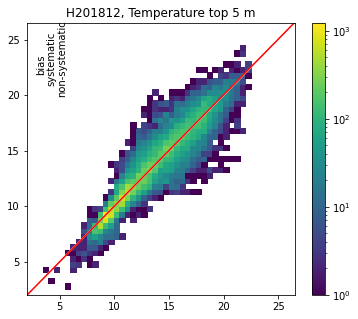

In [35]:
temp1 = read_pieces(pieces)
d201812 = plot_and_stats(temp1, 'H201812')
d201812.style.format(myformat)

In [36]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_TS_20150101-20150331.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_TS_20150401-20150630.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_TS_20150701-20150930.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_TS_20151001-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_TS_20160101-20160331.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_TS_20160401-20160630.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160601_20160930.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160901_20161231.csv',
     #    '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
     #     '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
     #     '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
     #     '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20150101_20151231.csv',
     #     '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20160101_20161231.csv',
     #     '/home/sallen/202007/H201905/ObsModel_H201905_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,40478,-0.051,1.1,0.027,-0.0015,-0.071,0.053,1.1,-0.2


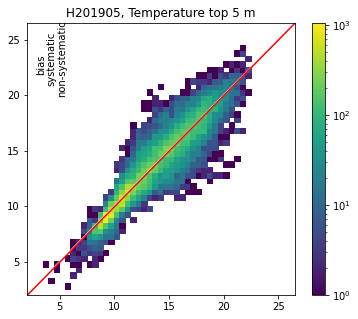

In [37]:
temp1 = read_pieces(pieces)
d201905 = plot_and_stats(temp1, 'H201905')
d201905.style.format(myformat)

In [14]:
# missing psfts 2015, 2017
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20151001-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160101-20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160401-20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20160701-20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20161001-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
      #   '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
      #   '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
      #   '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
      #   '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
     #    '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150101_20150331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150401_20150630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20150701_20150930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20151001_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160101_20160331.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160301_20160630.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20160601_20160930.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20161001_20161231.csv',
     #    '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170101_20170331.csv',
     #    '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170401_20170630.csv',
     #    '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20170701_20170930.csv',
     #    '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ferry_20171001_20171231.csv',
          '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
     #     '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,294305,-0.061,1.1,0.028,-0.004,-0.11,0.065,1.1,-0.4


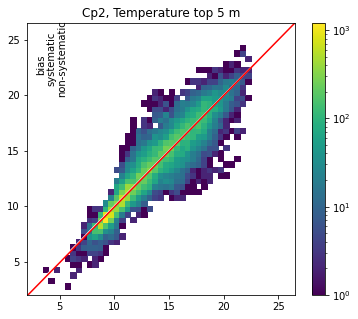

In [15]:
temp1 = read_pieces(pieces)
dCp2 = plot_and_stats(temp1, 'Cp2')
dCp2.style.format(myformat)

In [16]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ferry_20170101_20171231.csv'
        )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,473401,0.072,1.2,0.03,-0.024,-0.24,0.091,1.2,-0.57


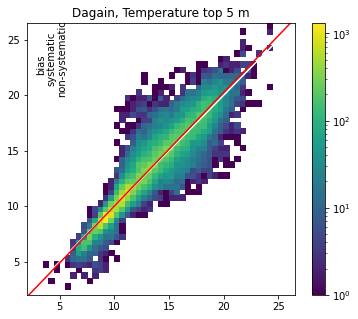

In [17]:
temp3 = read_pieces(pieces)
Dagain = plot_and_stats(temp3, 'Dagain')
Dagain.style.format(myformat)

In [18]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ferry_20170101_20171231.csv')

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,474268,0.073,1.2,0.03,-0.02,-0.18,0.084,1.2,-0.53


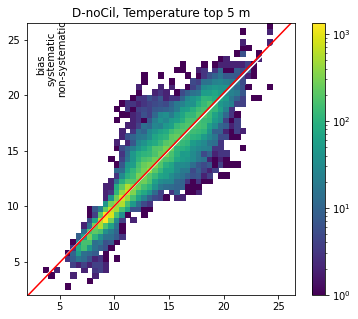

In [19]:
temp2 = read_pieces(pieces)
DnoC = plot_and_stats(temp2, 'D-noCil')
DnoC.style.format(myformat)

In [20]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ferry_20170101_20171231.csv')

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,474872,0.073,1.2,0.03,-0.024,-0.23,0.091,1.2,-0.6


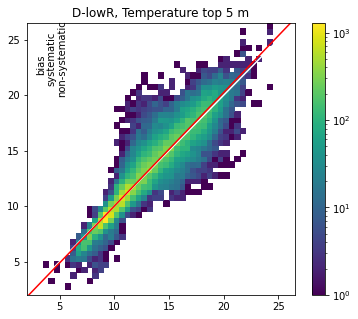

In [21]:
temp2 = read_pieces(pieces)
DlowR = plot_and_stats(temp2, 'D-lowR')
DlowR.style.format(myformat)

In [16]:
pieces = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
   #       '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
   #      '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
    #     '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150101_20150331.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150401_20150630.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20150701_20150930.csv',
        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20151001_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160101_20160331.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160401_20160630.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20160701_20160930.csv',
    '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20161001_20161231.csv',
  #       '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ferry_20170101_20171231.csv'
)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,289586,-0.11,1.1,0.028,0.0065,-0.025,0.11,1.1,-0.43


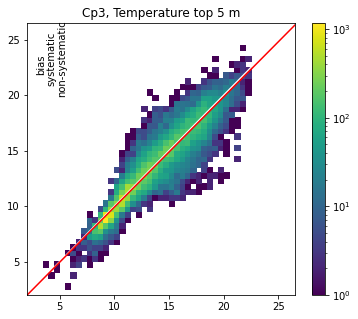

In [17]:
temp2 = read_pieces(pieces)
modCp3 = plot_and_stats(temp2, 'Cp3')
modCp3.style.format(myformat)

In [18]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
    #     '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
    #      '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
    #     '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20160101_20161231.csv',
    #     '/home/sallen/202007/202007F/ObsModel_202007F_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,292088,-0.13,1.1,0.027,0.0079,-0.024,0.12,1.1,-0.44


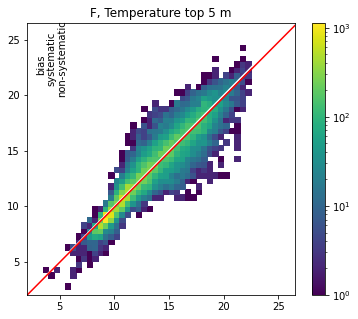

In [19]:
temp2 = read_pieces(pieces)
modF = plot_and_stats(temp2, 'F')
modF.style.format(myformat)

In [20]:
pieces1 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150101_20151231.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20160101_20161231.csv',
   #        '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20170101_20171231.csv',
   #       '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20170101_20171231.csv',
   #       '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20170101_20171231.csv',
          )
pieces2 = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150101_20150331.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150401_20150630.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20150701_20150930.csv',
           '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20151001_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20160101_20161231.csv',
    #      '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ferry_20170101_20171231.csv',
          )
pieces3 = (
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20160101_20161231.csv',
  #  '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1f0_ferry_20170101_20171231.csv',
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp1,291381,-0.21,1.2,0.036,0.028,0.16,0.2,1.2,-0.35


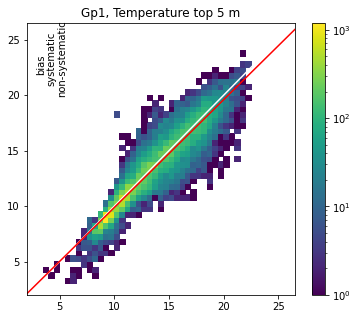

In [21]:
temp2 = read_pieces(pieces1+pieces2)
modGp1 = plot_and_stats(temp2, 'Gp1')
modGp1.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp1f0,292317,-0.21,1.2,0.036,0.028,0.16,0.2,1.2,-0.48


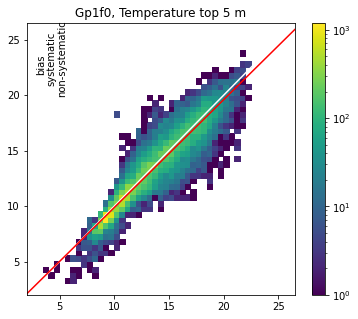

In [22]:
temp2 = read_pieces(pieces1+pieces3)
modGp1f0 = plot_and_stats(temp2, 'Gp1f0')
modGp1f0.style.format(myformat)

In [23]:
pieces1 = ('/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20160101_20161231.csv',
           '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20160101_20161231.csv',
    #       '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20170101_20171231.csv',
    #       '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20170101_20171231.csv',
    #       '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20170101_20171231.csv'
         )
pieces2 = (
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ferry_20150101_20151231.csv',
   
         )
pieces3 = (
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20150101_20151231.csv',
    '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20160101_20161231.csv',
 #   '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ferry_20170101_20171231.csv',
)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp2,161447,-0.27,1.3,0.039,0.05,0.39,0.27,1.3,-0.73


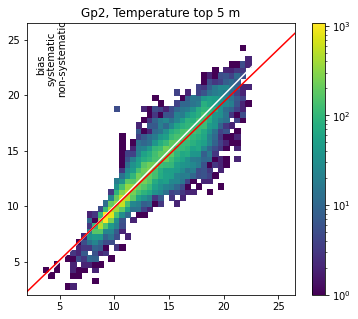

In [24]:
temp2 = read_pieces(pieces1+pieces2)
modGp2 = plot_and_stats(temp2, 'Gp2')
modGp2.style.format(myformat)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Gp2f0,292317,-0.27,1.3,0.039,0.05,0.39,0.27,1.3,-0.58


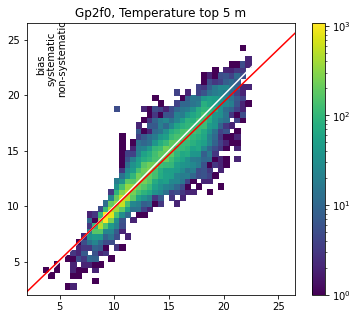

In [25]:
temp2 = read_pieces(pieces1+pieces3)
modGp2f0 = plot_and_stats(temp2, 'Gp2f0')
modGp2f0.style.format(myformat)

In [33]:
pieces = ('/home/sallen/202007/202007H/ObsModel_202007H_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_ferry_20150101_20151231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_ferry_20160101_20161231.csv',
         '/home/sallen/202007/202007H/ObsModel_202007H_ferry_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H,470659,0.023,1.2,0.029,-0.009,-0.094,0.032,1.2,-0.55


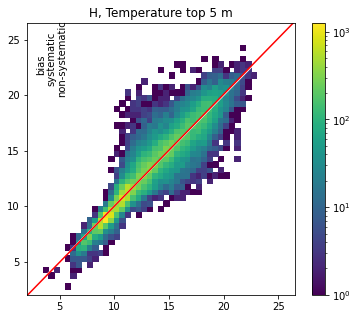

In [34]:
temp2 = read_pieces(pieces)
modH = plot_and_stats(temp2, 'H')
modH.style.format(myformat)

In [32]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel_202111_ctd_20150101_20151231.csv',
        '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psfts_20150101_20151231.csv',
           '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pugts_20150101_20151231.csv',
  #        '/data/sallen/results/MEOPAR/202111/ObsModel_202111_ferry_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_ctd_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psfts_20160101_20161231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pugts_20160101_20161231.csv',
 #        '/data/sallen/results/MEOPAR/202111/ObsModel_202111_ferry_20160101_20161231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
modv202111,40579,-0.21,1.1,0.029,0.027,0.15,0.2,1.1,-0.16


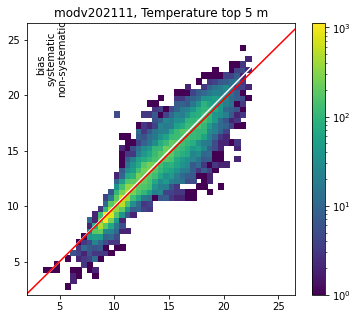

In [33]:
temp2 = read_pieces(pieces)
modv202111 = plot_and_stats(temp2, 'modv202111')
modv202111.style.format(myformat)

In [28]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [39]:
alltogether = pd.concat([d201812, d201905, 
                         dCp2, #Dagain, DnoC, DlowR, 
                         modCp3, modF, #modH, 
                         modGp1, modGp2, modGp1f0, modGp2f0,
                        modv202111,], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,40590,0.0098,1.1,0.026,-0.0037,-0.038,0.013,1.1,-0.22
H201905,40478,-0.051,1.1,0.027,-0.0015,-0.071,0.053,1.1,-0.2
Cp2,294305,-0.061,1.1,0.028,-0.004,-0.11,0.065,1.1,-0.4
Cp3,289586,-0.11,1.1,0.028,0.0065,-0.025,0.11,1.1,-0.43
F,292088,-0.13,1.1,0.027,0.0079,-0.024,0.12,1.1,-0.44
Gp1,291381,-0.21,1.2,0.036,0.028,0.16,0.2,1.2,-0.35
Gp2,161447,-0.27,1.3,0.039,0.05,0.39,0.27,1.3,-0.73
Gp1f0,292317,-0.21,1.2,0.036,0.028,0.16,0.2,1.2,-0.48
Gp2f0,292317,-0.27,1.3,0.039,0.05,0.39,0.27,1.3,-0.58
modv202111,40579,-0.21,1.1,0.029,0.027,0.15,0.2,1.1,-0.16


Interesting! New bathy only makes a small change but the new waves increase the negative bias.  BUT changes are very small.